# dnadna: Deep Neural Architecture for DNA
This notebook reproduces an example of population size history inference performed by the SPIDNA deep learning method described in the paper ["Deep learning for population size history inference: design, comparison and combination with approximate Bayesian computation"](https://www.biorxiv.org/content/10.1101/2020.01.20.910539v1.full.pdf) (Sanchez et al.). It uses the dnadna package that can be installed by following the instructions [here](https://mlgenetics.gitlab.io/dnadna/introduction.html#installation).

We will simulate SNP data for six scenarios with population size history defined by hand (e.g. expansion, decline or bottleneck) and use a pretrained version of SPIDNA to reconstruct these population size histories. This architecture has been trained using data generated with msprime and prior described in Sanchez et al. [methods section](https://www.biorxiv.org/content/10.1101/2020.01.20.910539v1.full.pdf#page=9). Therefore, using the same architecture to infer population size histories far from this prior might lead to high prediction errors.

## Import

In [1]:
import numpy as np
import pandas as pd
import os
import msprime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

## Simulate scenario
First, we simulate six different scenarios with 21 time steps using msprime (Kelleher et al., 2016).

In [2]:
def simulate_scenario(population_size, population_time, seed, num_replicates, mutation_rate, recombination_rate, 
                      segment_length, num_sample):
    
    demographic_events = [msprime.PopulationParametersChange(
                time=population_time[i],
                growth_rate=0,
                initial_size=population_size[i]) for i in range(1, len(population_time))]

    population_configurations = [msprime.PopulationConfiguration(
                sample_size=num_sample,
                initial_size=population_size[0])]

    tree_sequence = msprime.simulate(
                length=segment_length,
                population_configurations=population_configurations,
                demographic_events=demographic_events,
                recombination_rate=recombination_rate,
                mutation_rate=mutation_rate,
                num_replicates=num_replicates,
                random_seed=seed)
    pos = []
    snp = []
    for i, rep in enumerate(tree_sequence):
                # In this tutorial we encode SNP position information as a vector of distances (in bp) between SNPs
                positions = [variant.site.position for variant in rep.variants()]
                positions = np.array(positions) - np.array([0] + positions[:-1])
                positions = positions.astype(int)  
                pos.append(positions)
                SNPs = rep.genotype_matrix().T.astype(np.uint8)
                snp.append(SNPs)
    data = [[snp[i], pos[i]] for i in range(len(snp))]
    data = [np.vstack([d[1], d[0]]) for d in data]
    return data

In [3]:
# Population sizes are defined on a log10 scale
scenarios = {'Medium': [3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7],   
             'Large': 4.7 * np.ones(shape=21, dtype='float'), 
             'Decline': [2.5, 2.5, 3, 3, 3, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6, 4.6], 
             'Expansion': [4.7, 4.7, 4.7, 4.6, 4.6, 4.5, 4.4, 4.3, 4, 3.7, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4], 
             'Bottleneck': [4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.8, 4.5, 4.15, 3.8, 4.3, 4.8, 4.55, 4.3, 4.05, 3.8, 3.8, 3.8, 3.8], 
             'Zigzag': [4.8, 4.8, 4.8, 4.5, 4.15, 3.8, 4.15, 4.5, 4.8, 4.5, 4.15, 3.8, 4.3, 4.8, 4.55, 4.3, 4.05, 3.8, 3.8, 3.8, 3.8]}
scenarios = {k:10**np.array(scenarios[k]) for k in scenarios.keys()}
seed = 2
num_replicates = 100  # number of independent genomic regions
mutation_rate = 1e-8
segment_length = 2e6  # length of the region in bp
time_rate = 0.06
tmax = 130000
num_time_windows = 21
num_sample = 50  # number of haploid individuals
population_time = [(np.exp(np.log(1 + time_rate * tmax) * i /
                  (num_time_windows - 1)) - 1) / time_rate for i in
                  range(num_time_windows)]

snp_data = {}
for k in scenarios.keys():
    print(f'Simulating scenario \"{k}\"')
    population_size = scenarios[k]
    recombination_rate = np.random.uniform(low=1e-9, high=1e-8)
    snp_data[k] = simulate_scenario(population_size, population_time, seed, num_replicates, mutation_rate, 
                             recombination_rate, segment_length, num_sample)
 

Simulating scenario "Medium"
Simulating scenario "Large"
Simulating scenario "Decline"
Simulating scenario "Expansion"
Simulating scenario "Bottleneck"
Simulating scenario "Zigzag"


## Save data
We save data into ```.npz``` files with two keywords ```SNP``` and ```POS``` for the SNP matrix and its associated position vector (here distance between SNPs, in bp).

In [6]:
data_path = 'data'
Path(data_path).mkdir(parents=True, exist_ok=True)
file_list = []
for k in snp_data.keys():
    Path(os.path.join(data_path, k)).mkdir(parents=True, exist_ok=True)
    for i in range(len(snp_data[k])):
        SNP = snp_data[k][i][1:,:]
        POS = snp_data[k][i][0,:]
        npz_save_path = os.path.join(data_path, k, f'{k}_{i}')
        np.savez(npz_save_path, POS=POS, SNP=SNP)
        file_list.append(f'{npz_save_path}.npz')
with open('file_list', 'a') as f:
    f.write('\n'.join(file_list))

## Inference with dnadna package

You can use the _predict_ command with arguments _--progress-bar_ (displays a progress bar for prediction) as follows:

In [7]:
! dnadna predict pretrained_SPIDNA/pretrained_SPIDNA_net.pth $(cat file_list) --progress-bar -o result.csv  

2022-08-16 20:53:33;     INFO;  The following transform list will be applied to the data: training: Compose([Crop(max_snp=400, max_indiv=None, keep_polymorphic_only=True)])
100%|████████████████████████████████████████| 600/600 [05:48<00:00,  1.72snp/s]


Alternatively you can use Bash wildcards when specifying paths in dnadna commands such as:

In [8]:
! dnadna predict pretrained_SPIDNA/pretrained_SPIDNA_net.pth data/*/*.npz -o result_bis.csv --progress-bar

2022-08-16 20:59:23;     INFO;  The following transform list will be applied to the data: training: Compose([Crop(max_snp=400, max_indiv=None, keep_polymorphic_only=True)])
100%|████████████████████████████████████████| 600/600 [06:05<00:00,  1.64snp/s]



From the log message showing what transformations where applied to the data you can see that SNP matrices were cropped: for each region, all individuals are kept (max_indiv=None), but only the first 400 SNPs are kept (max_snp=400).
In general, to show available transforms:

`dnadna predict pretrained_SPIDNA/pretrained_SPIDNA_net.pth $(cat file_list) -t show`

or, if you have a training config file:

`dnadna predict pretrained_SPIDNA/pretrained_SPIDNA_net.pth $(cat file_list) -t show --config PATH-TO-PREDICT-CONFIG-FILE`

For more details check the documentation on creating new transforms https://mlgenetics.gitlab.io/dnadna/prediction.html

## Generate Plot

In [9]:
from matplotlib.offsetbox import AnchoredText

Scenario Medium 
 Relative (Squared) Error averaged over the 21 demographic parameters: 0.0045
 Removing recent period (up to 47 generations ago): 0.0045
Scenario Large 
 Relative (Squared) Error averaged over the 21 demographic parameters: 0.0046
 Removing recent period (up to 47 generations ago): 0.0034
Scenario Decline 
 Relative (Squared) Error averaged over the 21 demographic parameters: 0.0134
 Removing recent period (up to 47 generations ago): 0.0061
Scenario Expansion 
 Relative (Squared) Error averaged over the 21 demographic parameters: 0.0039
 Removing recent period (up to 47 generations ago): 0.0039
Scenario Bottleneck 
 Relative (Squared) Error averaged over the 21 demographic parameters: 0.006
 Removing recent period (up to 47 generations ago): 0.0051
Scenario Zigzag 
 Relative (Squared) Error averaged over the 21 demographic parameters: 0.007
 Removing recent period (up to 47 generations ago): 0.0051


[None, None, None, None, None, None]

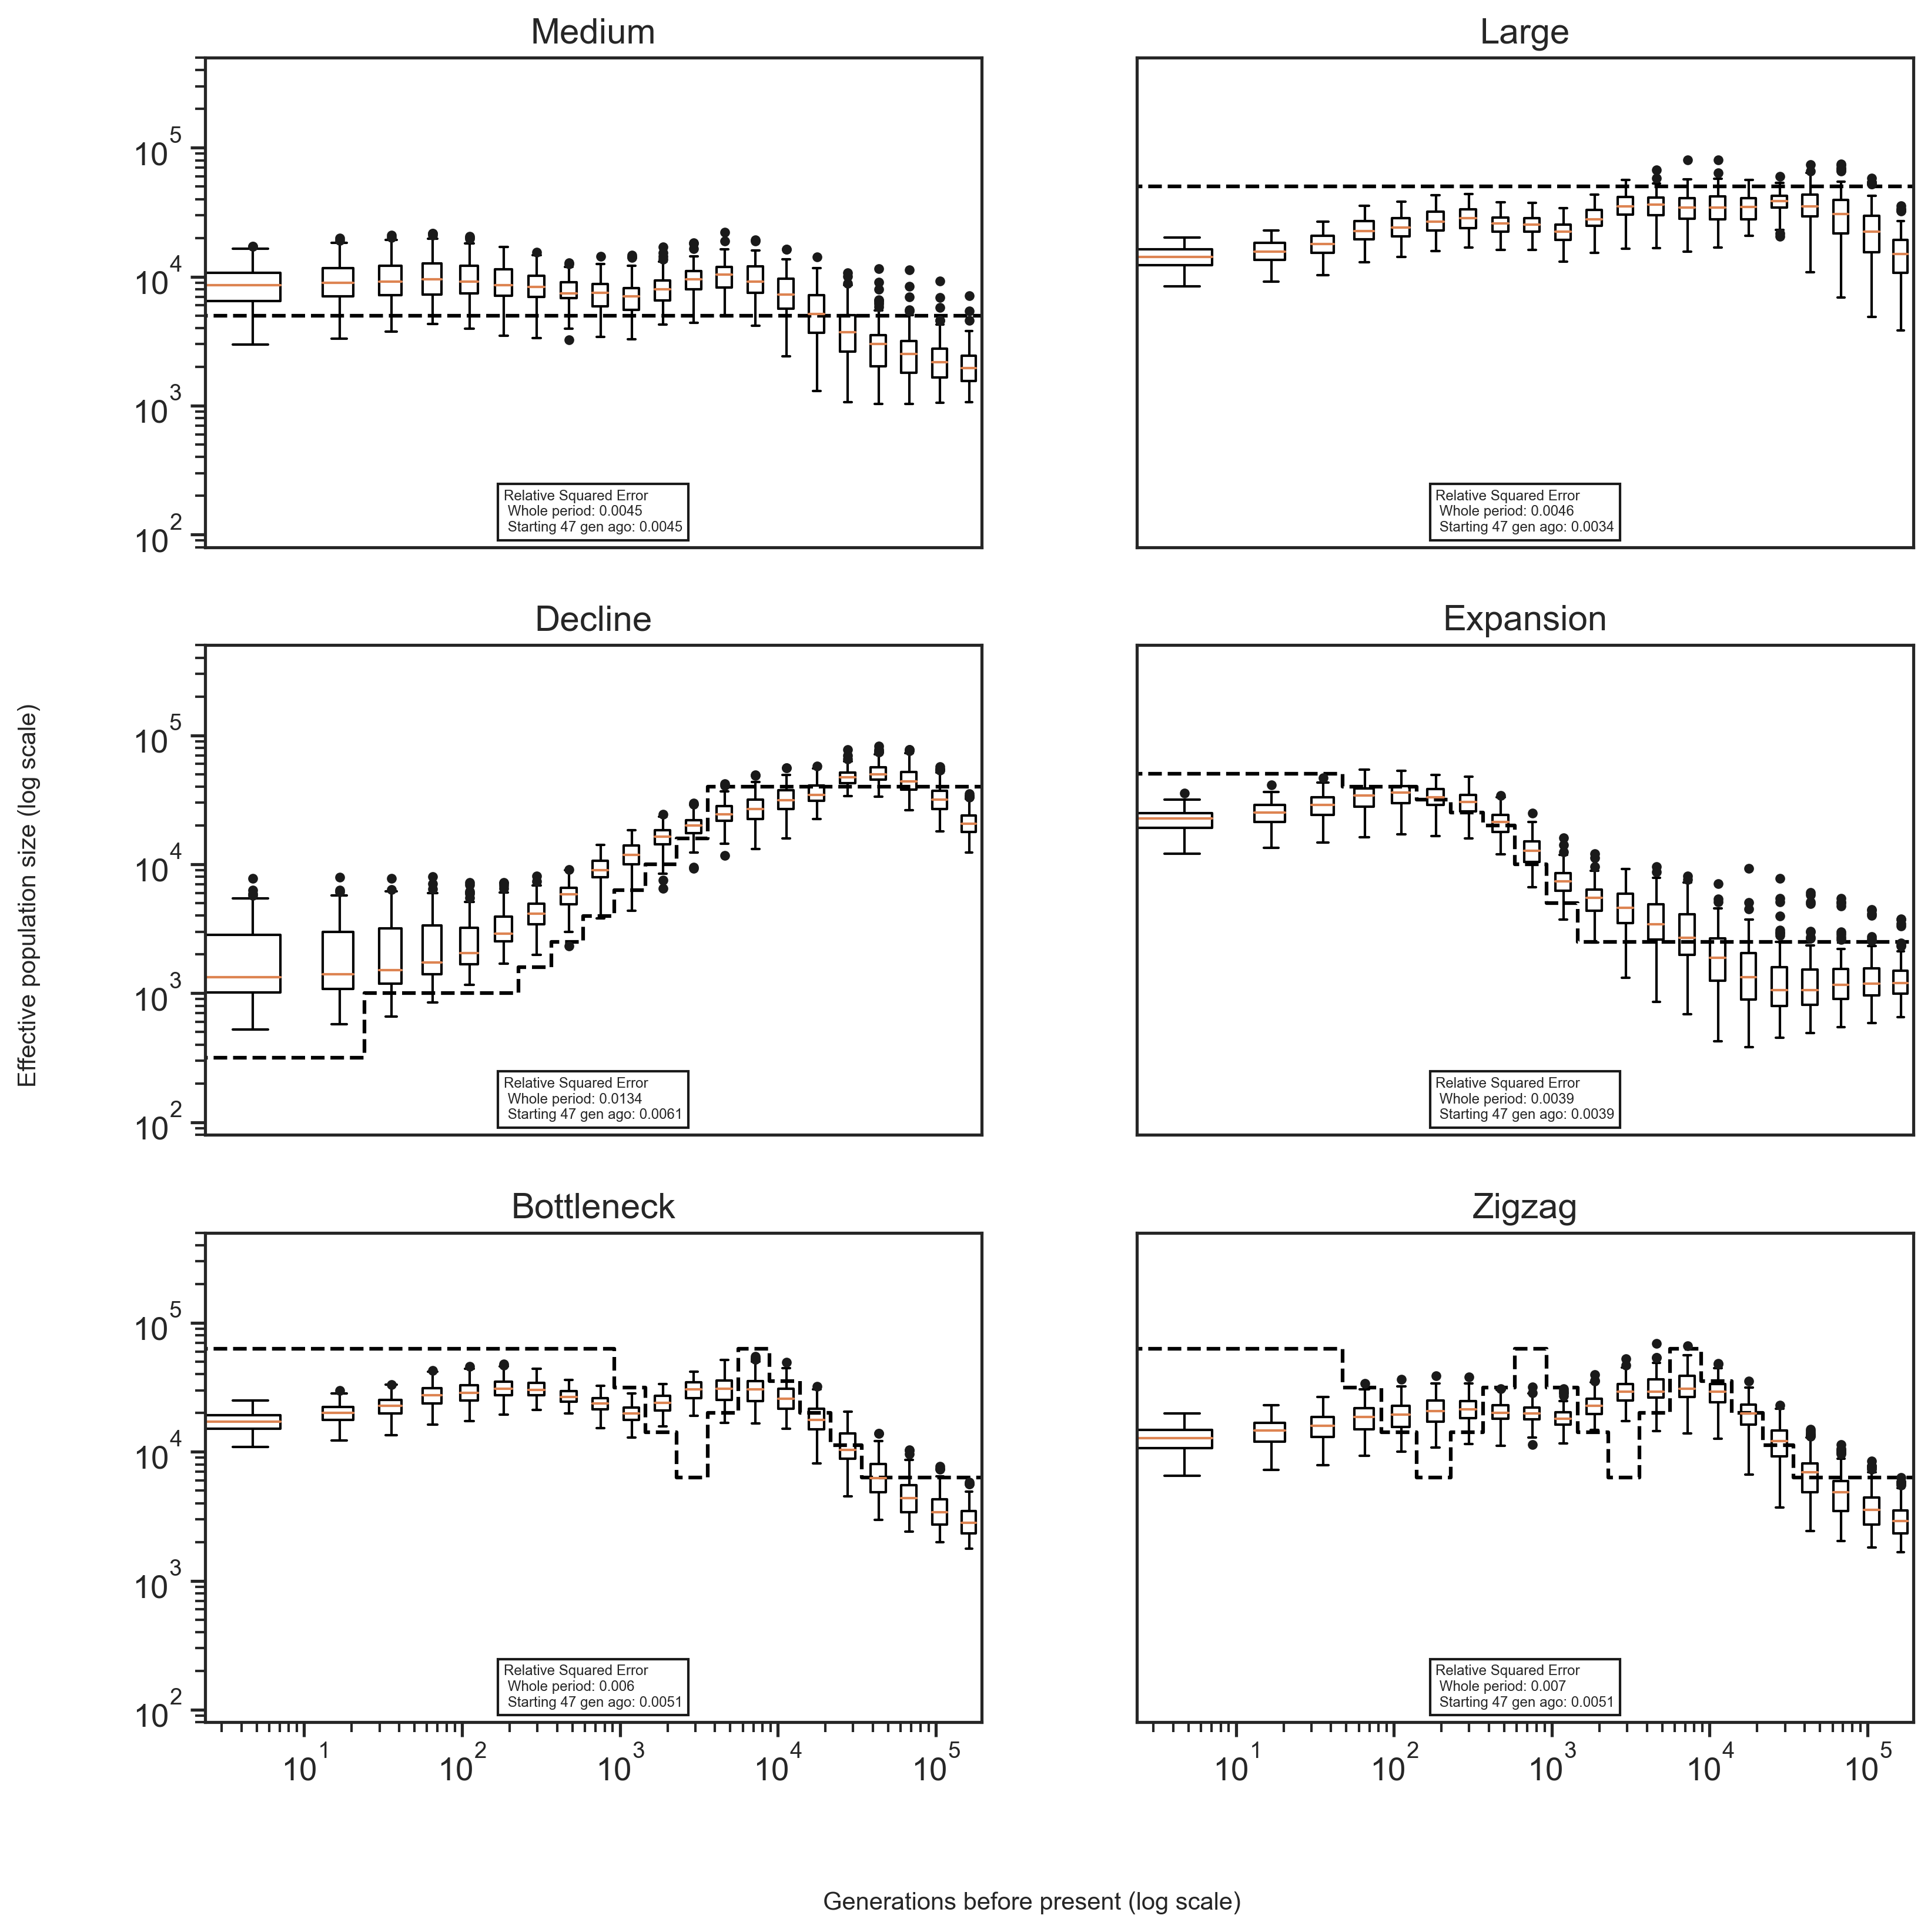

In [10]:
# Load predictions
predictions = pd.read_csv('result.csv')
predictions['scenario_name'] = predictions.apply(lambda path: path[0].split('/')[-2], axis=1)
predictions = predictions.drop(columns=['path'])

sns.set(style="ticks", font_scale=1.2)
fig = plt.figure(dpi=300, figsize=(15/1.2, 15/1.2))

# Add one step to represent the infinite time
population_time1 = np.append(population_time, population_time[-1]*1.5)

axs = []
i = 1
for key in scenarios.keys():
    axs.append(fig.add_subplot(3, 2, i))
    
    population_size = np.append(np.array(scenarios[key]), scenarios[key][-1])
    ax = sns.lineplot(x=population_time1, y=population_size, drawstyle='steps-post', color=(0,0,0))
    ax.lines[0].set_linestyle("--")
    
    population_time2 = np.append(np.array(population_time1), 0)
    boxplot_widths = (population_time2[1:] - population_time2[:-1])/2
    boxplot_widths[-1] = - boxplot_widths[-1]
    boxplot_positions = population_time2[:-1] + boxplot_widths
    dat = predictions.loc[predictions['scenario_name'] == key].iloc[:, range(21)]
    dat.columns = population_time1[:-1]
    dat = np.transpose(dat)
    plt.boxplot([dat.loc[i] for i in dat.index], vert=True, positions=boxplot_positions[:-1],
                widths=boxplot_widths[:-1], sym='k.')
    
    plt.ylabel('')
    plt.xlabel('')
    plt.ylim(80, 5e5)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(key)
    i += 1
    
    # Estimate for the "genome" is the average of estimates for each independent genomic regions
    genome_pred = np.array(np.log(dat).mean(axis=1))
    true = np.log(scenarios[key])
    # Relative Squared Error averaged over the 21 demographic parameters (in log scale)
    RSE_all = np.round(np.mean( ((true - genome_pred)/true)**2 ), decimals=4)
    t=3 # time step from which considering history
    # Relative Squared Error averaged without recent times  
    RSE_ancient = np.round(np.mean(((true[t:] - genome_pred[t:])/true[t:])**2), decimals=4)
    print(f'Scenario {key} \n Relative (Squared) Error averaged over the 21 demographic parameters: {RSE_all}\n'
          f' Removing recent period (up to {int(np.round(dat.index[t]))} generations ago): {RSE_ancient}')

    anchored_text = AnchoredText(f'Relative Squared Error\n Whole period: {RSE_all}\n'+f' Starting {int(np.round(dat.index[t]))} gen ago: {RSE_ancient}', 
                                 loc='lower center', prop={'fontsize':'xx-small'})
    ax.add_artist(anchored_text)

    
fig.text(0.5, 0.04, 'Generations before present (log scale)', ha='center')
fig.text(0.04, 0.5, 'Effective population size (log scale)', va='center', rotation='vertical')
[ax.get_xaxis().set_visible(False) for ax in axs[:4]]
[ax.get_yaxis().set_visible(False) for ax in [axs[1], axs[3], axs[5]]]
[ax.margins(x=0) for ax in axs]

# plt.savefig('prediction_popsize.pdf')

## Using different data transformations
Suppose you want to use pretrained SPIDNA on other .npz files that had more individuals. This specific network was trained on 50 haploids, although it could predict quite well for sampling sizes close enough to 50 (check Sanchez et al. 2020), we decide here to use exaclty 50 haploids - taken randomly.

You can (1) create a new transform list (with the name of your choice) in a predict config file; then (2) give the filepath and transform name as arguments to  `dnadna predict`

### 0. Faking real dataset
with 75 individuals, 20 independent regions

In [11]:
num_sample = 75  # number of haploid individuals
num_replicates = 20
snp_data2 = {}
for k in ['Expansion']:
    print(f'Simulating scenario \"{k}\"')
    population_size = scenarios[k]
    recombination_rate = np.random.uniform(low=1e-9, high=1e-8)
    snp_data2[k] = simulate_scenario(population_size, population_time, seed, num_replicates, mutation_rate, 
                             recombination_rate, segment_length, num_sample)
data_path = 'real'
Path(data_path).mkdir(parents=True, exist_ok=True)
for k in snp_data2.keys():
    Path(os.path.join(data_path, k)).mkdir(parents=True, exist_ok=True)
    for i in range(len(snp_data2[k])):
        SNP = snp_data2[k][i][1:,:]
        POS = snp_data2[k][i][0,:]
        npz_save_path = os.path.join(data_path, k, f'{k}_{i}')
        np.savez(npz_save_path, POS=POS, SNP=SNP) 

Simulating scenario "Expansion"


### 1. Write predict config file 

In [12]:
%%writefile my_predict_config.yml
predict_transforms:
    real_to_spidna:
        # Subsample randomly 50 individuals out of the 'num_sample' simulated
        - subsample: 
            size: 50
        # Then crop the matrices to the first 400 SNPs:
        - crop:
            max_snp: 400
            max_indiv: null
            keep_polymorphic_only: true


Writing my_predict_config.yml


### 2a. Showing available transforms 

In [13]:
! dnadna predict pretrained_SPIDNA/pretrained_SPIDNA_net.pth real/*/*.npz --config my_predict_config.yml -t show

2022-08-16 21:05:33;     INFO;  Available transform lists: 
- real_to_spidna: [{'subsample': {'size': 50}}, {'crop': {'max_snp': 400, 'max_indiv': None, 'keep_polymorphic_only': True}}]
- training: [{'crop': {'max_snp': 400, 'max_indiv': None, 'keep_polymorphic_only': True}}]
- validation: [{'crop': {'max_snp': 400, 'max_indiv': None, 'keep_polymorphic_only': True}}]
- test: [{'crop': {'max_snp': 400, 'max_indiv': None, 'keep_polymorphic_only': True}}]


### 2b. Predicting with desired transform list (real_to_spidna) applied

In [14]:
! dnadna predict pretrained_SPIDNA/pretrained_SPIDNA_net.pth real/*/*.npz --config my_predict_config.yml -t real_to_spidna --progress-bar -o results_real.csv

2022-08-16 21:05:34;     INFO;  The following transform list will be applied to the data: real_to_spidna: Compose([Subsample(size=50, keep_polymorphic_only=True), Crop(max_snp=400, max_indiv=None, keep_polymorphic_only=True)])
100%|██████████████████████████████████████████| 20/20 [00:12<00:00,  1.66snp/s]


In [15]:
! head -3 results_real.csv

path,population_size_0,population_size_1,population_size_2,population_size_3,population_size_4,population_size_5,population_size_6,population_size_7,population_size_8,population_size_9,population_size_10,population_size_11,population_size_12,population_size_13,population_size_14,population_size_15,population_size_16,population_size_17,population_size_18,population_size_19,population_size_20
/home/fjay/Documents/WORK/GITLAB/private/dnadna/examples/real/Expansion/Expansion_0.npz,19964.794921875,22332.2109375,25430.544921875,31141.341796875,34041.09375,35091.5078125,35475.77734375,28479.556640625,19208.58203125,10470.5009765625,6896.33984375,5185.94873046875,4064.08984375,3990.225830078125,3964.890380859375,4066.8193359375,3837.311279296875,3487.58984375,3250.580322265625,2860.229736328125,2527.031982421875
/home/fjay/Documents/WORK/GITLAB/private/dnadna/examples/real/Expansion/Expansion_10.npz,23012.98046875,26075.830078125,29592.14453125,35170.20703125,36704.703125,35119.6640625,32663.6